## Feature Extraction and Slicing

In [7]:
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from sklearn.decomposition import NMF

def decompose_melspectrogram(S, n_components=10):
    # Use 'nndsvd' initialization and adjust tolerance
    nmf = NMF(n_components=n_components, init='nndsvd', random_state=0, max_iter=2000, tol=1e-3)
    
    # Fit NMF to the spectrogram data and transform
    activations = nmf.fit_transform(S.T)
    components = nmf.components_
    
    return components.T, activations.T


# Function to extract and decompose melspectrogram
def extract_features(y, sr=22050, n_fft=2048, hop_length=512, n_mels=128, n_components=5):
    # Melspectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB_non_negative = S_dB + abs(np.min(S_dB))

    # Decompose the melspectrogram
    components, activations = decompose_melspectrogram(S_dB_non_negative, n_components=n_components)
    
    # Return the components and activations
    return components, activations

# Function to slice features based on the DataFrame
def slice_song_features(df, song_id, features, sr=22050, hop_length=512):
    song_df = df[df['SongID'] == song_id]
    feature_slices = []
    labels = []

    for _, row in song_df.iterrows():
        start_frame = librosa.time_to_frames(row['start_time'], sr=sr, hop_length=hop_length)
        end_frame = librosa.time_to_frames(row['end_time'], sr=sr, hop_length=hop_length)
        feature_slice = features[:, start_frame:end_frame]
        feature_slices.append(feature_slice)
        labels.append(row['label'])

    return feature_slices, labels


# Load DataFrame
df = pd.read_csv(r'../data/dataframes/clean_labeled.csv')
hop_length = 512
sr = 22050

# Process each song
all_slices = {}
all_labels = {}

for song_id in tqdm(df['SongID'].unique(), desc="Processing songs"):
    audio_file = f"../data/audio_files/processed/{song_id}.mp3"
    y, sr = librosa.load(audio_file, sr=sr)
    components, activations = extract_features(y=y)  # Unpack returned tuple
    slices, labels = slice_song_features(df, song_id, activations, sr)  # Use activations for slicing
    all_slices[song_id] = slices
    all_labels[song_id] = labels

# Binary encode labels
for song_id in all_labels:
    all_labels[song_id] = np.array([1 if label == 'chorus' else 0 for label in all_labels[song_id]])

Processing songs:  11%|█         | 36/332 [00:37<06:14,  1.26s/it]C:\Users\denni\anaconda3\envs\AudioInfoRetrieval\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
Processing songs:  13%|█▎        | 44/332 [00:46<04:43,  1.02it/s]C:\Users\denni\anaconda3\envs\AudioInfoRetrieval\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
Processing songs:  20%|██        | 68/332 [01:15<05:04,  1.16s/it]C:\Users\denni\anaconda3\envs\AudioInfoRetrieval\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
Processing songs:  21%|██        | 69/332 [01:16<05:04,  1.16s/it]C:\Users\denni\anaconda3\envs\AudioInfoRetrieval\Lib\site-packages\sklearn\deco

In [2]:
import pickle

# Path to the .pkl files
all_labels_path = r'../data/pkl/all_labels.pkl'
all_slices_path = r'../data/pkl/all_slices.pkl'

# Load all_labels
with open(all_labels_path, 'rb') as file:
    all_labels = pickle.load(file)

# Load all_slices
with open(all_slices_path, 'rb') as file:
    all_slices = pickle.load(file)

## Data Preparation for LSTM

### Padding Sequences: All sequences must have the same length for LSTM input.

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

# Find the maximum length of any slice
max_length = max(max(feature_slice.shape[1] for feature_slice in slices) for slices in all_slices.values())

# Pad the sequences for each song and convert labels to categorical
padded_slices = {}
padded_labels = {}

for song_id, slices in tqdm(all_slices.items(), desc="Processing songs"):
    num_features = slices[0].shape[0]  # Assuming all slices have the same shape as the first slice
    padded_song_slices = []
    
    for feature_slice in slices:
        # Ensure feature_slice is a 2D array (features, time)
        assert feature_slice.ndim == 2, "feature_slice must be a 2D array"
        
        # Ensure the feature slice has the correct number of features
        assert feature_slice.shape[0] == num_features, f"Inconsistent number of features: {feature_slice.shape[0]} instead of {num_features}"

        # Calculate padding amounts
        time_padding = max_length - feature_slice.shape[1]
        assert time_padding >= 0, "time_padding must be non-negative"
        
        # Pad the feature slice along the time axis
        padding = ((0, 0), (0, time_padding))  # No padding for features, only pad time axis
        padded_feature_slice = np.pad(feature_slice, padding, 'constant', constant_values=0)
        padded_song_slices.append(padded_feature_slice)
    
    # Stack the padded slices
    padded_slices[song_id] = np.stack(padded_song_slices)
    
    # Keep binary labels as they are (do not convert to categorical)
    padded_labels[song_id] = np.array(all_labels[song_id])  # Assuming all_labels[song_id] is already binary

Processing songs: 100%|██████████| 332/332 [00:00<00:00, 3553.13it/s]


In [5]:
# Deleting variables to free up memory
# List of variable names to keep
vars_to_keep = ['padded_slices', 'padded_labels']

# Iterate over the list of all global variables
for name in list(globals()):
    # Check if the current variable is not in the list of variables to keep
    if name not in vars_to_keep:
        # Delete the variable
        del globals()[name]

In [9]:
import numpy as np
# Stack all the slices and labels to create a single dataset
X = np.concatenate([p for p in padded_slices.values()])
y = np.concatenate([l for l in padded_labels.values()])

## Define the model

In [36]:
with open(r'../data/pkl/X.pkl', 'rb') as file:
    X = pickle.load(file)

with open(r'../data/pkl/y.pkl', 'rb') as file:
    y = pickle.load(file)

In [40]:
# Deleting variables to free up memory
# List of variable names to keep
vars_to_keep = ['X', 'y']

# Iterate over the list of all global variables
for name in list(globals()):
    # Check if the current variable is not in the list of variables to keep
    if name not in vars_to_keep:
        # Delete the variable
        del globals()[name]

## Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

In [46]:
# Deleting variables to free up memory
# List of variable names to keep
vars_to_keep = ['X_train', 'y_train', 'X_val', 'y_val', 'model']

# Iterate over the list of all global variables
for name in list(globals()):
    # Check if the current variable is not in the list of variables to keep
    if name not in vars_to_keep:
        # Delete the variable
        del globals()[name]

In [13]:
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model

input_dim = X_train.shape[-1]  # Number of features
timesteps = X_train.shape[1]  # Sequence length

# Encoder
inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(128, activation='relu', return_sequences=False)(inputs)
encoded = Dense(64, activation='relu')(encoded)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
# Train the encoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_split=0.2)
# Transform data with encoder
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

Epoch 1/50
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x00000261A32ADF80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x00000261A32ADF80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. O

In [35]:
import numpy as np
from tensorflow.keras.layers import Input, Masking, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential


# Expand the dimensions to add the timestep dimension
X_train_encoded_reshaped = np.expand_dims(X_train_encoded, axis=1)
X_val_encoded_reshaped = np.expand_dims(X_val_encoded, axis=1)

# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

# Define model
model = Sequential([
    Masking(mask_value=0., input_shape=(1, 64)),  # Adjust input shape
    Bidirectional(LSTM(128, return_sequences=False, activation='relu')),
    Dropout(0.5),  # Adjust dropout rate
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with a custom optimizer and learning rate schedule
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping with patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with callbacks for early stopping and learning rate scheduling
history = model.fit(
    X_train_encoded_reshaped, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_encoded_reshaped, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val_encoded_reshaped)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Calculate precision, recall, and F1-score
report = classification_report(y_val, y_val_pred_binary, target_names=['non-mix-in', 'mix-in'])
print(report)

Epoch 1/50
9/9 [==============================] - 2s 36ms/step - loss: 0.8193 - accuracy: 0.5583 - val_loss: 0.6186 - val_accuracy: 0.6749 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 0s 5ms/step - loss: 0.6144 - accuracy: 0.6860 - val_loss: 0.5669 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 0s 5ms/step - loss: 0.5641 - accuracy: 0.7016 - val_loss: 0.5874 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 0s 5ms/step - loss: 0.5536 - accuracy: 0.7273 - val_loss: 0.5248 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 0s 5ms/step - loss: 0.5204 - accuracy: 0.7383 - val_loss: 0.5445 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 0s 5ms/step - loss: 0.5227 - accuracy: 0.7539 - val_loss: 0.5256 - val_accuracy: 0.7466 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 0s 5ms/step - loss: 0.4918 - accuracy: 0.77

## Plot training history

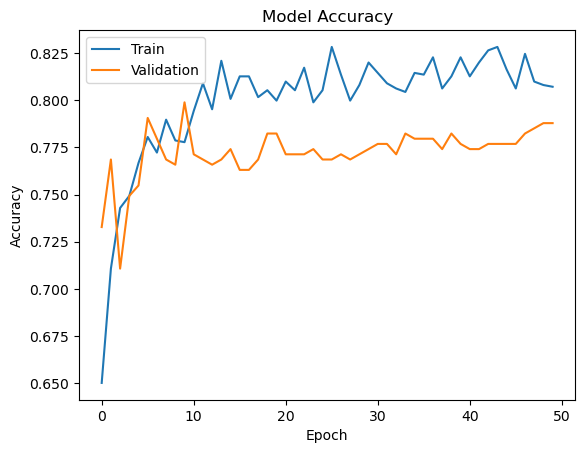

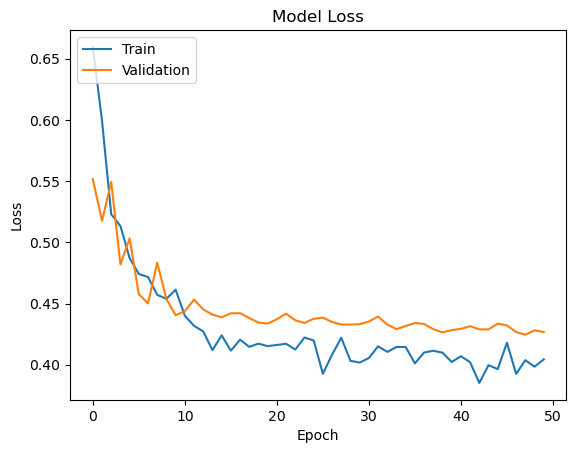

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()